# 11. Time Series Fundamentals

## What we're going to cover

* Downloading and formatting time series data (the historical price of Bitcoin)
* Writing a preprocessing function to prepare our time series data
* Setting up multiple time series modelling experiments
* Building a multivariate model to take in multivariate time series data
* Replicating the N-Beats algorithm using TensorFlow
* Making forecasts with prediction intervals
* Demonstrating why time series forecasting can be BS with the turkey problem

## Time series inputs and outputs

What will the price of Bitcoin be tomorrow? -> Actual Output<br>
[batch_size, window_size] -> [horizon]

## Get Data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin

In [1]:
!curl "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv" --output "Data/Time_Series/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  174k    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  174k  100  174k    0     0   229k      0 --:--:-- --:--:-- --:--:--  229k


## Importing time series with pandas

In [2]:
import pandas as pd

# Lets read in the Bitcoin data and parse the dates
df = pd.read_csv('Data/Time_Series/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', parse_dates=["Date"], index_col=["Date"])

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


We've collected the historical price of Bitcoin for the past 8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can mean thousands to tens of thousands to millions).

A smaller number of samples is typically what you'll run into with time series data problems.

**Note:** The seasonality of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 265 because we collect one sample per day meaning we'll get 365 samples per year.

## Types of Time Series Data

* Trend: time series has a clear long-term increase or decrease (may or may not be linear)
* Seasonal: time series affected by seasonal factors such as time of year (eg increased sales towards the end of the year) or day of week
* Cyclic: time series shows rises and falls over an unfixed period, these tend to be longer/more variable than seasonal patterns.

In [4]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns = {"Closing Price (USD)": "Price"})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


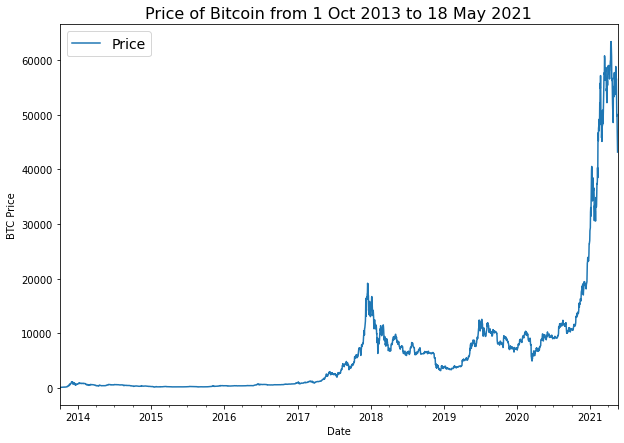

In [5]:
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize = (10, 7));
plt.ylabel("BTC Price");
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize = 16);
plt.legend(fontsize = 14);

In [6]:
import csv
from datetime import datetime

date_list = []
price_list = []
with open('Data/Time_Series/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter= ",")
    next(csv_reader) # skip first line
    for line in csv_reader:
        date_list.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as datetime objects
        price_list.append(float(line[2])) # get the closing price as float

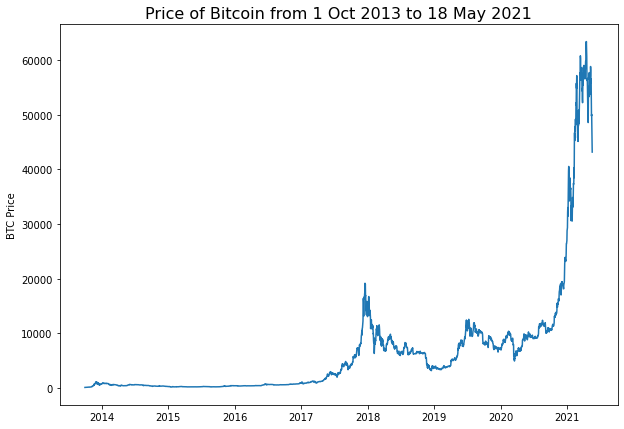

In [7]:
import numpy as np

plt.figure(figsize = (10, 7));
plt.plot(date_list, price_list);
plt.ylabel("BTC Price");
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize = 16);

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [8]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices.Price.to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [9]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

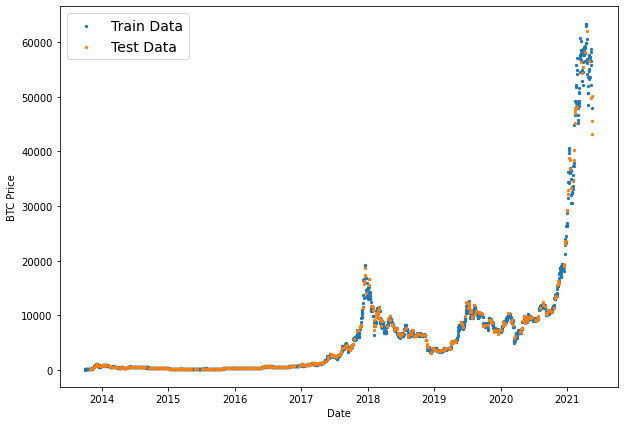

In [10]:
# Lets plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s = 5, label = "Train Data")
plt.scatter(X_test, y_test, s = 5, label = "Test Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize = 14)
plt.show()

## Create train and test sets for time series (the right way)

In [11]:
# create train and test splits the right way for time series data
split_size = int(0.8 * len(prices))

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

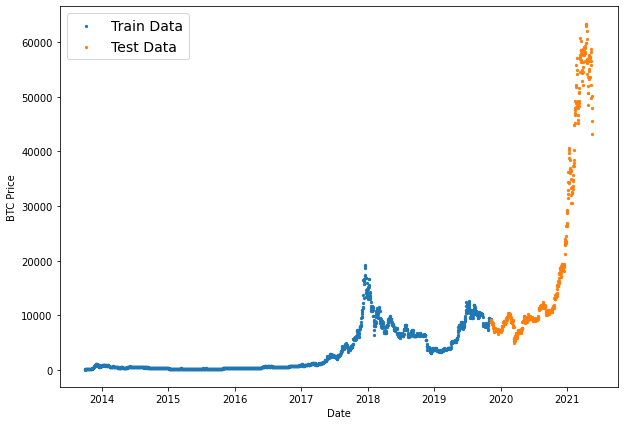

In [12]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s = 5, label = "Train Data")
plt.scatter(X_test, y_test, s = 5, label = "Test Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize = 14)
plt.show()

In [13]:
### Create a plotting function
def plot_time_series(timesteps, values, format = ".", start = 0, end = None, label = None):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps)
    Parameters
    ---------
    timesteps : array of timesteps values
    values : array of values across time
    format : style of plot, default '.'
    start : where to start the plot (setting a value will index from start of timesteps)
    end : where to end the plot (similar to start but for the end)
    label : label to show on plot about values, default None
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label = label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)

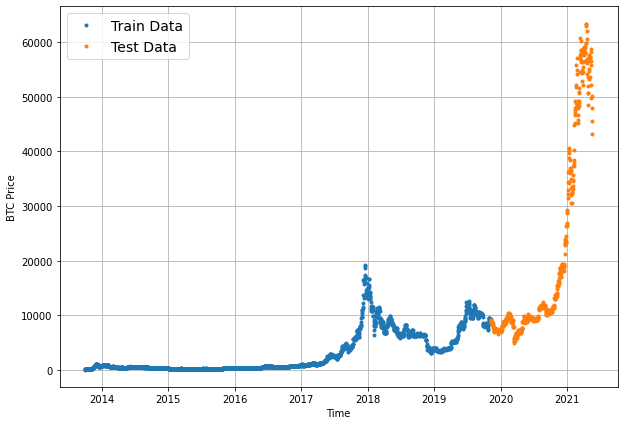

In [14]:
plt.figure(figsize = (10, 7))
plot_time_series(timesteps=X_train, values = y_train, label = "Train Data")
plot_time_series(timesteps=X_test, values = y_test, label = "Test Data")

## Modelling Experiments

* **Horizon** : number of timesteps into the future we're going to predict
* **Window size** : number of timesteps we're going to use to predict **horizon**

|Experiment|Model|horizon|window|
|----------|-----|-------|------|
|0|Naive model (baseline)|||
|1|Dense model|1|7|
|2|Same as model 1|1|30|
|3|Same as model 1|7|30|
|4|Conv1D|1|7|
|5|LSTM|1|7|
|6|Same as model 1 (but with multivariate data|1|7|
|7|N-BEATS algorithm|1|7|
|8|Ensemble (multiple models stacked together|1|7|
|9|Future Prediction model|1|7|
|10|Same as model 1 (but with turkey data introduced|1|7|

## Model 0: Naive Model (Baseline)

The formula looks like this:

$$\hat{y}(t) = y(t - 1)$$

In english:
> The prediction at timestep "t" is equal to the value at timestep "t-1"

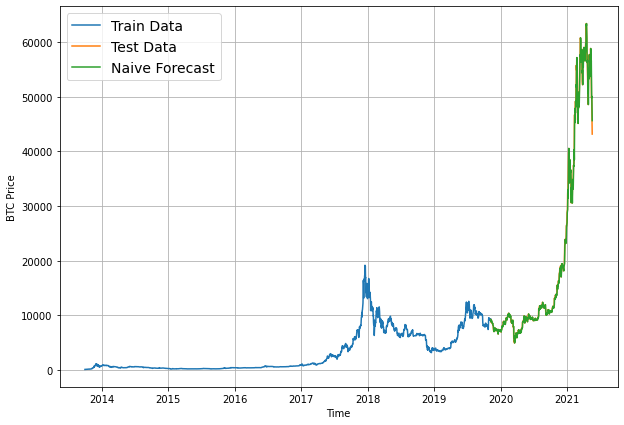

In [15]:
# Plot naive forecast
naive_forecast = y_test[:-1]

plt.figure(figsize = (10, 7))
plot_time_series(X_train, y_train, label = "Train Data", format = "-")
plot_time_series(X_test, y_test, label = "Test Data", format="-")
plot_time_series(X_test[1:], naive_forecast, label = "Naive Forecast", format="-")

## Evaluating a time series model

Let's look into some evaluation metrics for time-series

What are we doing?

We're predicting a number, so that means we have a form of regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error

The main thing we're evaluating here is: how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?

|Metric Name|Metric Formula|Tensorflow code|When to use|
|-----------|--------------|---------------|-----------|
|Mean absolute error (MAE)|$MAE = \frac{\sum_{i=1}^{n}abs(y_i - x_i)}{n}$|tf.keras.losses.MAE() or tf.keras.losses.mean_absolute_error()|As a great starter metric for any regression problem.|
|Mean square error (MSE)|$MSE = \frac{\sum_{i=1}^{n}abs(Y_i - \hat{Y_i})^2}{n}$|tf.keras.losses.MSE() or tf.keras.losses.mean_square_error()|When larger errors are more significant than smaller errors.|
|Root mean squared error (RMSE)|$RMSE = \sqrt{MSE}$|tf.sqrt(tf.metrics.mean_square_error())|Similar to MSE but as interpretable as MAE (RMSE is in same units are target)|
|(Scaled) Mean absolute percentage error (MAPE/sMAPE)|$MAPE = mean(abs(100e_t/y_t))$|tf.keras.metrics.mean_absolute_percentage_error()|Recommend not to use by Hyndman and Koehler|
|Mean absolute scaled error (MASE)|$q_j = \frac{e_j}{\frac{1}{T-1}\sum_{t=2}^{T}abs(y_t-y_{t-1})}$|Custom or See sktime's mase_loss()|A scaled error is > 1 if the forecast is worse than the naive and <1 if the forecast is better than the naive|

For all of the above metrics, **lower is better**, for example, an MAE of 0 is better than an MAE of 100.

In [16]:
import tensorflow as tf

In [20]:
# MASE implementation

def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data)
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true - y_pred)) # our seasonality is 1 day (hence the shift of 1)

    return mae / mae_naive_no_season

In [21]:
mean_absolute_scaled_error(y_true = y_test[1:], y_pred = naive_forecast).numpy()

1.0

In [22]:
# Create a function to take in model predictions and truth values and return evaluation metrics

def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype = tf.float32)
    y_pred = tf.cast(y_pred, dtype = tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {"mae":mae.numpy(), "mse": mse.numpy(), "rmse": rmse.numpy(), "mape":mape.numpy(), "mase": mase.numpy()}

That's one good looking evaluation function!

Lets now see if it works

In [23]:
naive_results = evaluate_preds(y_true = y_test[1:], y_pred = naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 1.0}

## Other models you can use for baselines and for actual forecasts

In this notebook, we're focussed on TensorFlow and deep learning models.

However, there are plenty of other styles of time series forecasting models you may want to experiment with:
https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

## Format Data Part 2: Window our dataset

Why do we window?

We window our dataset to convert our data into a supervised learning problem

Windowing for one week

[0,1,2,3,4,5,6] -> [7]<br>
[1,2,3,4,5,6,7] -> [8]<br>
[2,3,4,5,6,7,8] -> [9]

In [27]:
HORIZON = 1
WINDOW_SIZE = 7

def get_labelled_windows(x, horizon = HORIZON):
    """
    Creates labels for windowed dataset.

    Eg if horizon = 1
    Input: [0, 1, 2, 3, 4, 5, 6] -> Output: [0,1,2,3,4,5,6] -> [7] 
    """
    return x[:,:-horizon], x[:, -horizon:]

In [28]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis = 0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6]])>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[7]])>)

We've got a way to label our windowed data.

However it only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops but that would be quite slow for large time series

To speed things up, we'll leverage NumPy's array indexing.

Our function will:
1. Create a window step of specific window size (eg [0,1,2,3,4,5,6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[
    [0,1,2,3,4,5,6],
    [1,2,3,4,5,6,7],
    [2,3,4,5,6,7,8]
    ....
]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (eg. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

In [41]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size = WINDOW_SIZE, horizon = HORIZON):
    """
    Turns a 1D array into a 2D array of sequential labelled windows of a window size with horizon size labels.
    """
    # 1. Create a window of specified window_size (add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size + horizon), axis = 0)

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis = 1)

    # 3. Index on the target array (a time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon = horizon)

    return windows, labels

In [42]:
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [43]:
# View the first 3 windows/labels
for i in range(3):
    print(f'Window: {full_windows[i]} -> Label: {full_labels[i]}')

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


Alternatively, we can use `tf.keras.preprocessing.timeseries_dataset_from_array()` to the same effect.

## Turning windows into training and test sets

In [44]:
# Make the train/test splits

def make_train_test_splits(windows, labels, test_split = 0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1 - test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]

    return train_windows, test_windows, train_labels, test_labels

In [45]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [46]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [47]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [50]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[: -HORIZON - 1]), y_train[WINDOW_SIZE:])

True

## Make a modelling Checkpoint

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example, if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

In [51]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path = "Checkpoint/Time_Series"):
    return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name),
                                              verbose = 0,
                                              save_best_only = True)

## Model 1: Dense Model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:

* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch size of 128  (previously we've used 32)
* 100 epochs

Why these values?

Picked with experimentation.

In [53]:
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Create a model
model_1 = tf.keras.Sequential(
    [
        layers.Dense(128, activation = 'relu', name = "hidden_layer"),
        layers.Dense(HORIZON, activation = "linear", name = "output_layer") # linear activation is the same as having no activation.
    ], name = "model_1_dense"
)

# Compile the model
model_1.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae", "mse"]
)

# Fit the model
history_model_1 = model_1.fit(
    x = train_windows,
    y = train_labels,
    epochs = 100,
    verbose = 1,
    batch_size = 128,
    validation_data = (test_windows, test_labels),
    callbacks = [create_model_checkpoint(model_name = model_1.name)]
)

Epoch 1/100
18/18 [==============================] - 4s 72ms/step - loss: 780.3455 - mae: 780.3455 - mse: 2312725.7500 - val_loss: 2279.6528 - val_mae: 2279.6528 - val_mse: 12772731.0000
Epoch 2/100
18/18 [==============================] - 1s 56ms/step - loss: 247.6756 - mae: 247.6756 - mse: 285481.2188 - val_loss: 1005.9992 - val_mae: 1005.9992 - val_mse: 3441833.5000
Epoch 3/100
18/18 [==============================] - 1s 51ms/step - loss: 188.4116 - mae: 188.4116 - mse: 171891.6094 - val_loss: 923.2863 - val_mae: 923.2863 - val_mse: 2868221.2500
Epoch 4/100
18/18 [==============================] - 1s 46ms/step - loss: 169.4340 - mae: 169.4340 - mse: 151700.5625 - val_loss: 900.5871 - val_mae: 900.5871 - val_mse: 2683715.0000
Epoch 5/100
18/18 [==============================] - 1s 52ms/step - loss: 165.0895 - mae: 165.0895 - mse: 145490.7812 - val_loss: 895.2237 - val_mae: 895.2237 - val_mse: 2564574.0000
Epoch 6/100
18/18 [==============================] - 1s 48ms/step - loss: 158.5

In [54]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 12ms/step - loss: 585.9755 - mae: 585.9755 - mse: 1197802.0000


[585.9755249023438, 585.9755249023438, 1197802.0]

In [55]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model('Checkpoint/Time_Series/model_1_dense')
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 14ms/step - loss: 568.9510 - mae: 568.9510 - mse: 1171743.7500


[568.9509887695312, 568.9509887695312, 1171743.75]

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only psuedo forecasts because actual forecasts are into the future). Let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [61]:
def make_preds(model, input_data):
    """
    Uses model to make predictions on input_data
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [62]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 7ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.712, 8769.886, 9015.712, 8795.519, 8723.811, 8730.112,
        8691.953, 8502.054, 8460.96 , 8516.548], dtype=float32)>)

In [63]:
model_1_results = evaluate_preds(tf.squeeze(test_labels), model_1_preds)
model_1_results

{'mae': 568.95105,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 1.0}

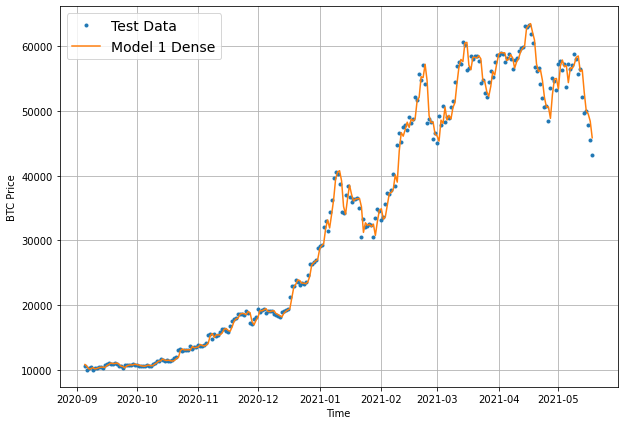

In [70]:
offset = 300

plt.figure(figsize = (10, 7))
plot_time_series(X_test[-len(test_windows):], values = test_labels[:, 0], start = offset, label = "Test Data", format=".")
plot_time_series(X_test[-len(test_windows):], model_1_preds, start = offset, label = "Model 1 Dense", format="-")

## Model 2: Dense (window = 30, horizon = 1)

In [72]:
full_windows_30, full_labels_30 = make_windows(prices, window_size = 30, horizon = 1)
full_windows_30.shape, full_labels_30.shape

((2757, 30), (2757, 1))

In [73]:
train_windows_30, test_windows_30, train_labels_30, test_labels_30 = make_train_test_splits(full_windows_30, full_labels_30, 0.2)
train_windows_30.shape, test_windows_30.shape, train_labels_30.shape, test_labels_30.shape

((2205, 30), (552, 30), (2205, 1), (552, 1))

In [74]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Create a model
model_2 = tf.keras.Sequential(
    [
        layers.Dense(128, activation = 'relu', name = "hidden_layer"),
        layers.Dense(HORIZON, activation = "linear", name = "output_layer") # linear activation is the same as having no activation.
    ], name = "model_2_dense"
)

# Compile the model
model_2.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae", "mse"]
)

# Fit the model
history_model_2 = model_2.fit(
    x = train_windows_30,
    y = train_labels_30,
    epochs = 100,
    verbose = 0,
    batch_size = 128,
    validation_data = (test_windows_30, test_labels_30),
    callbacks = [create_model_checkpoint(model_name = model_2.name)]
)

INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_Series\model_2_dense\assets
INFO:tensorflow:Assets written to: Checkpoint/Time_S

In [75]:
# Evaluate model 3 on test data
model_2.evaluate(test_windows_30, test_labels_30)

18/18 [==============================] - 0s 17ms/step - loss: 665.5611 - mae: 665.5611 - mse: 1431146.3750


[665.5610961914062, 665.5610961914062, 1431146.375]

In [76]:
model_2 = tf.keras.models.load_model('Checkpoint/Time_Series/model_2_dense')
model_2.evaluate(test_windows_30, test_labels_30)

18/18 [==============================] - 0s 14ms/step - loss: 616.3276 - mae: 616.3276 - mse: 1309629.8750


[616.3275756835938, 616.3275756835938, 1309629.875]

In [77]:
model_2_preds = make_preds(model_2, test_windows_30)
model_2_results = evaluate_preds(tf.squeeze(test_labels_30), model_2_preds)
model_2_results

18/18 [==============================] - 0s 5ms/step


{'mae': 616.3275,
 'mse': 1309630.0,
 'rmse': 1144.3907,
 'mape': 2.8121033,
 'mase': 1.0}

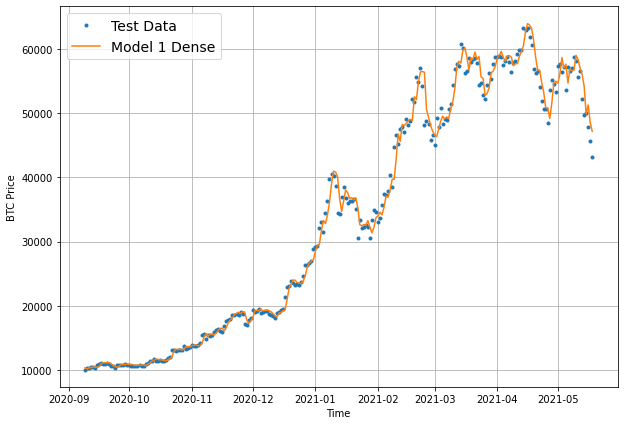

In [79]:
offset = 300

plt.figure(figsize = (10, 7))
plot_time_series(X_test[-len(test_windows_30):], values = test_labels_30[:, 0], start = offset, label = "Test Data", format=".")
plot_time_series(X_test[-len(test_windows_30):], model_2_preds, start = offset, label = "Model 1 Dense", format="-")

## Model 3: Building, fitting and evaluating a model with a larger horizon size

In [85]:
HORIZON = 7
full_windows_30, full_labels_7 = make_windows(prices, window_size = 30, horizon = HORIZON)
train_windows_30, test_windows_30, train_labels_7, test_labels_7= make_train_test_splits(full_windows_30, full_labels_7, 0.2)

train_dataset_win_30_hor_7 = tf.data.Dataset.from_tensor_slices((train_windows_30, train_labels_7)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset_win_30_hor_7 = tf.data.Dataset.from_tensor_slices((test_windows_30, test_labels_7)).batch(128).prefetch(tf.data.AUTOTUNE)

In [89]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_3 = tf.keras.Sequential(
    [
        layers.Dense(128, activation = "relu", name = "hidden_layer"),
        layers.Dense(HORIZON, activation = "linear", name = "output_layer")
    ], name = "model_3"
)

# Compile the model
model_3.compile(
    loss = tf.keras.losses.MAE,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae", "mse"]
)

# Fit the model
history_model_3 = model_3.fit(
    train_dataset_win_30_hor_7,
    epochs = 100,
    steps_per_epoch = len(train_dataset_win_30_hor_7),
    validation_data = test_dataset_win_30_hor_7,
    validation_steps = len(test_dataset_win_30_hor_7),
    callbacks = [create_model_checkpoint(model_3.name)]
)

Epoch 1/100
18/18 [==============================] - 1s 40ms/step - loss: 849.9856 - mae: 849.9856 - mse: 2561418.5000 - val_loss: 2833.7292 - val_mae: 2833.7292 - val_mse: 21220530.0000
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 776.3613 - mae: 776.3613 - mse: 3236622.0000 - val_loss: 2921.7356 - val_mae: 2921.7356 - val_mse: 24942838.0000
Epoch 3/100
18/18 [==============================] - 1s 34ms/step - loss: 568.4208 - mae: 568.4208 - mse: 1409358.3750 - val_loss: 2418.1624 - val_mae: 2418.1624 - val_mse: 16601201.0000
Epoch 4/100
18/18 [==============================] - 1s 29ms/step - loss: 577.0087 - mae: 577.0087 - mse: 1590245.5000 - val_loss: 2253.5933 - val_mae: 2253.5933 - val_mse: 14206937.0000
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 580.2460 - mae: 580.2460 - mse: 1477238.0000 - val_loss: 2519.0977 - val_mae: 2519.0977 - val_mse: 17037242.0000
Epoch 6/100
18/18 [==============================] - 1s 31ms/step -

In [90]:
# Evaluate model 3 on test data
model_3.evaluate(test_dataset_win_30_hor_7)

5/5 [==============================] - 0s 9ms/step - loss: 1532.5125 - mae: 1532.5125 - mse: 7043627.0000


[1532.512451171875, 1532.512451171875, 7043627.0]

In [91]:
# Load in best model and evaluate
model_3 = tf.keras.models.load_model('Checkpoint/Time_Series/model_3')
model_3.evaluate(test_dataset_win_30_hor_7)

5/5 [==============================] - 0s 6ms/step - loss: 1467.0591 - mae: 1467.0591 - mse: 6728659.5000


[1467.05908203125, 1467.05908203125, 6728659.5]

In [100]:
model_3_preds = make_preds(model_3, test_dataset_win_30_hor_7)
model_3_results = evaluate_preds(tf.transpose(tf.squeeze(test_labels_7)), tf.transpose(model_3_preds))
model_3_results

5/5 [==============================] - 0s 6ms/step


{'mae': array([ 810.67  , 1335.675 , 1261.8787, 1679.6757, 1620.7969, 1695.685 ,
        1865.0322], dtype=float32),
 'mse': array([ 2006908. ,  4707959. ,  4827960. ,  7741320. ,  7849688.5,
         8940066. , 11026715. ], dtype=float32),
 'rmse': array([1416.6538, 2169.7832, 2197.262 , 2782.3228, 2801.7295, 2989.9944,
        3320.6497], dtype=float32),
 'mape': array([3.8086734, 6.352503 , 5.7951255, 7.6418533, 7.277156 , 7.651893 ,
        8.184331 ], dtype=float32),
 'mase': 1.0}

## Make our evaluation function work for larger horizons

In [101]:
model_3_results["mae"].shape

(7,)

In [102]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype = tf.float32)
    y_pred = tf.cast(y_pred, dtype = tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {"mae":mae.numpy(), "mse": mse.numpy(), "rmse": rmse.numpy(), "mape":mape.numpy(), "mase": mase.numpy()}

In [103]:
model_3_results = evaluate_preds(tf.transpose(tf.squeeze(test_labels_7)), tf.transpose(model_3_preds))
model_3_results

{'mae': 1467.0592,
 'mse': 6728659.5,
 'rmse': 2525.4849,
 'mape': 6.6730766,
 'mase': 1.0}

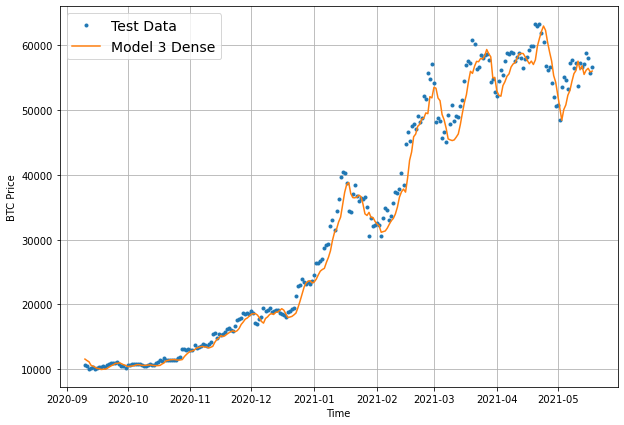

In [115]:
offset = 300

plt.figure(figsize = (10, 7))
plot_time_series(X_test[-len(test_windows_30):], values = test_labels_7[:, 0], start = offset, label = "Test Data", format=".")
plot_time_series(X_test[-len(test_windows_30):], tf.reduce_mean(model_3_preds, axis = 1), start = offset, label = "Model 3 Dense", format="-")

## Comparing our models so far

In [120]:
import pandas as pd
all_results = pd.DataFrame({"model_0_naive": naive_results, "model_1_hor_1_win_7": model_1_results, "model_2_hor_1_win_30": model_2_results, "model_3_hor_7_win_7": model_3_results})
all_results = all_results.transpose()
all_results

,mae,mse,rmse,mape,mase
model_0_naive,567.980225,1147547.00,1071.236206,2.516525,1.0
model_1_hor_1_win_7,568.951050,1171743.75,1082.471069,2.544898,1.0
model_2_hor_1_win_30,616.327515,1309630.00,1144.390747,2.812103,1.0
model_3_hor_7_win_7,1467.059204,6728659.50,2525.484863,6.673077,1.0


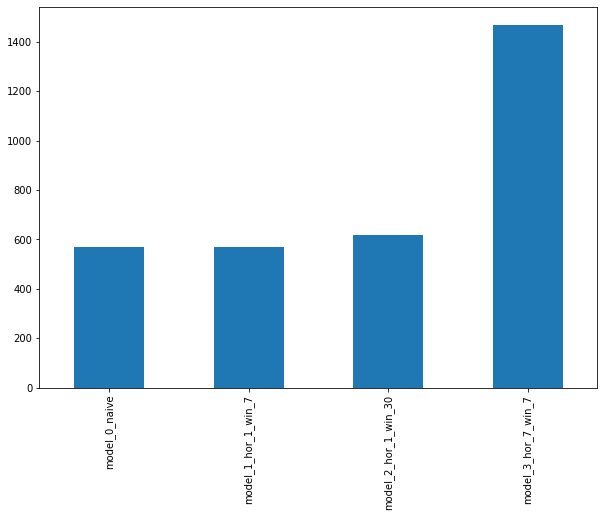

In [121]:
all_results["mae"].plot(figsize = (10, 7), kind = "bar");

Why are the naive results so good? One of the reasons could be the presence of autocorrelation in the data. If a time series has autocorrelation, it means the value at `t+1` is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to the value at yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naive model will often get fairly good results.